In [1]:
!pip install fastai2
!pip install fastai2>=0.0.11 graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

     |████████████████████████████████| 184 kB 2.8 MB/s 


In [2]:
from fastai2.vision.all import *

In [3]:
trn_path = Path('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/')
csv_path = Path('../input/all-csvs/')

In [4]:
fn = get_image_files(trn_path)
len(fn)

194082

In [5]:
labels = pd.read_csv(csv_path/'labels.csv')
labels.head()

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00008ce3c.jpg,0,0,0,0,0,0
1,ID_0000aee4b.jpg,0,0,0,0,0,0
2,ID_0002003a8.jpg,0,0,0,0,0,0
3,ID_0002081b6.jpg,1,0,1,0,0,0
4,ID_00027cbb1.jpg,0,0,0,0,0,0


For the baseline model we will only train a model to see if a bleed exists. Hence we only require the any column

In [6]:
labels = labels.iloc[:,0:2]
labels.head()

,ID,any
0,ID_00008ce3c.jpg,0
1,ID_0000aee4b.jpg,0
2,ID_0002003a8.jpg,0
3,ID_0002081b6.jpg,1
4,ID_00027cbb1.jpg,0


We start by creating dataloaders and our learner. [Learn more about how to train a simple classification model here](https://becominghuman.ai/my-first-deep-learning-hackathon-d98b20c5afc7)

In [7]:
dls = ImageDataLoaders.from_df(labels, trn_path, bs = 256, seed = 42)

In [8]:
len(dls.train_ds), len(dls.valid_ds)

(155266, 38816)

In [9]:
dls.bs

256

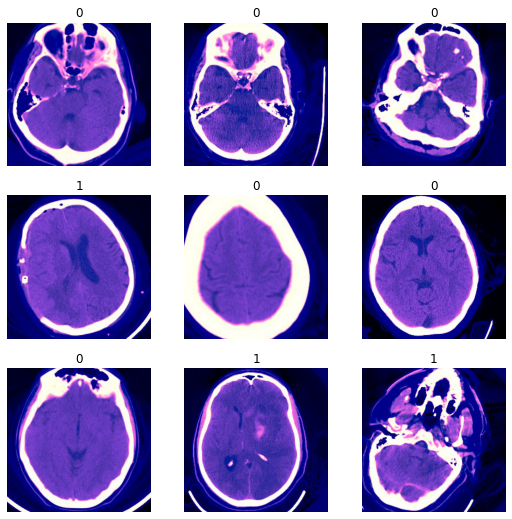

In [10]:
dls.show_batch()

In [11]:
learn = cnn_learner(dls, resnet18, pretrained=False, metrics=[error_rate, accuracy], model_dir='/kaggle')

We use Leslie Smith's famous learning rate finder to give us a good suggestion about the LR. [Learn more about why you need a good learning rate](https://becominghuman.ai/learning-rate-and-golf-87c8d4697e31)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

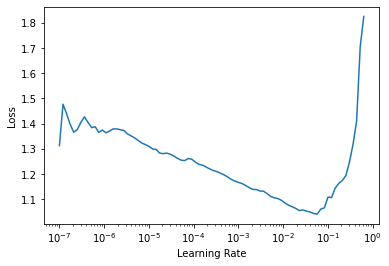

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(2, lr_max = 3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.368026,0.410629,0.183301,0.816699,12:41
1,0.282571,0.266792,0.111372,0.888628,11:25


In [14]:
learn.unfreeze()

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=9.12010818865383e-07)

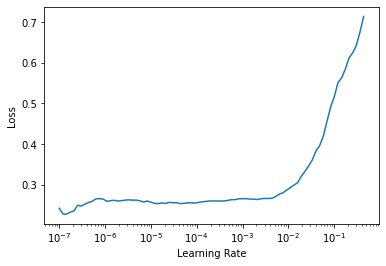

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(3, lr_max = 1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.268112,0.266647,0.111629,0.888371,11:24
1,0.264794,0.265100,0.110753,0.889247,11:26
2,0.262578,0.265090,0.110959,0.889041,11:20


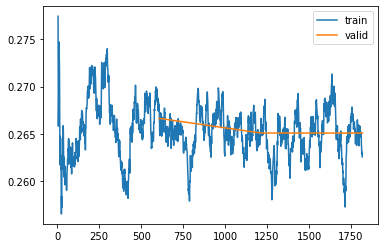

In [17]:
learn.recorder.plot_loss()

In [18]:
learn.save("/kaggle/working/baseline")

In [19]:
# interp = ClassificationInterpretation.from_learner(learn)

In [20]:
# confusion matrix
# 5/0

This time we use the pretrained weights. [Learn more about why you should be using transfer learning here](https://towardsdatascience.com/how-do-pretrained-models-work-11fe2f64eaa2)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy], model_dir='/kaggle')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=9.12010818865383e-07)

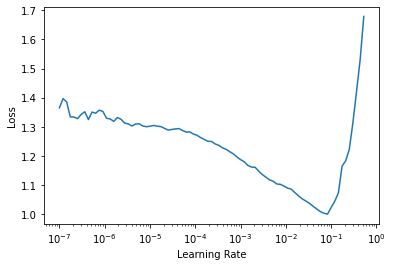

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(2, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.330689,0.309054,0.132420,0.867580,10:35
1,0.278455,0.279082,0.117091,0.882909,10:29


In [24]:
learn.unfreeze()

SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=9.999999747378752e-06)

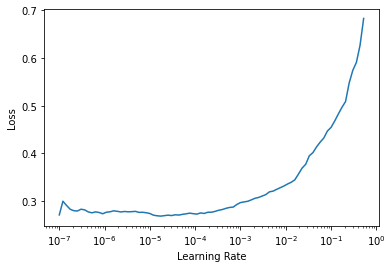

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.275559,0.273720,0.115184,0.884816,11:15
1,0.267963,0.269003,0.113020,0.886980,11:11
2,0.262165,0.268342,0.112763,0.887237,11:13


In [27]:
learn.save("/kaggle/working/pre_baseline-stage-1")

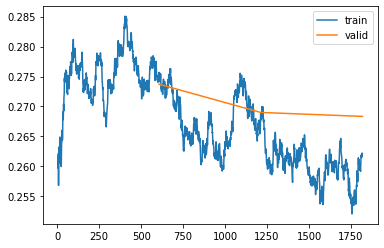

In [28]:
learn.recorder.plot_loss()

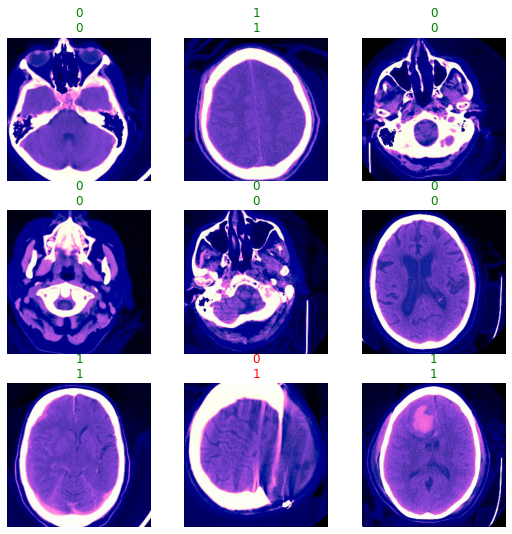

In [29]:
learn.show_results()

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=9.12010818865383e-07)

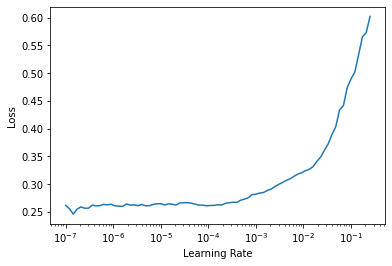

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(5, lr_max=1e-6)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.253486,0.267628,0.112454,0.887546,11:06
1,0.254113,0.265736,0.111500,0.888500,11:07
2,0.251009,0.264270,0.111372,0.888628,11:12
3,0.250041,0.263915,0.110521,0.889479,11:16
4,0.253454,0.263680,0.110856,0.889144,11:17


In [32]:
learn.save("/kaggle/working/pre_baseline-stage-2")

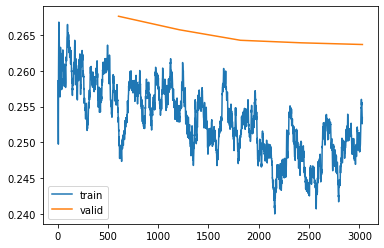

In [33]:
learn.recorder.plot_loss()

[One way to see if your model performs well is to use heatmaps](https://heartbeat.fritz.ai/heatmaps-and-convolutional-neural-networks-using-fast-ai-16d5b7d02a86). I couldn't plot them because of memory issues however you can always try. Fastai has a lot of other useful things like `most_confused` which shows you which 2 classes it was most confused amongst in case of multi class classification